In [30]:
import numpy as np
import tensorflow as tf

In [31]:
tf.onednn = 1


In [32]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [33]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

In [38]:
tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

In [7]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                        

In [10]:
!pip install visualkeras

Defaulting to user installation because normal site-packages is not writeable


In [11]:
import visualkeras

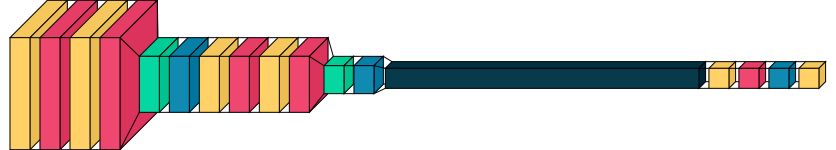

In [12]:
visualkeras.layered_view(model)

In [13]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
model.fit(train_images[..., np.newaxis], train_labels, 
          epochs=7, 
          batch_size=32, 
          validation_split=0.2,
          callbacks=[early_stopping])


Epoch 1/7
1500/1500 [==============================] - 42s 27ms/step - loss: 0.4984 - accuracy: 0.8280 - val_loss: 0.3131 - val_accuracy: 0.8908
Epoch 2/7
1500/1500 [==============================] - 40s 27ms/step - loss: 0.3198 - accuracy: 0.8858 - val_loss: 0.3050 - val_accuracy: 0.8872
Epoch 3/7
1500/1500 [==============================] - 40s 27ms/step - loss: 0.2869 - accuracy: 0.8984 - val_loss: 0.2286 - val_accuracy: 0.9137
Epoch 4/7
1500/1500 [==============================] - 40s 27ms/step - loss: 0.2599 - accuracy: 0.9072 - val_loss: 0.2473 - val_accuracy: 0.9114
Epoch 5/7
1500/1500 [==============================] - 39s 26ms/step - loss: 0.2445 - accuracy: 0.9131 - val_loss: 0.2228 - val_accuracy: 0.9178
Epoch 6/7
1500/1500 [==============================] - 40s 26ms/step - loss: 0.2243 - accuracy: 0.9195 - val_loss: 0.2144 - val_accuracy: 0.9225
Epoch 7/7
1500/1500 [==============================] - 40s 27ms/step - loss: 0.2121 - accuracy: 0.9245 - val_loss: 0.1911 - val_ac

In [15]:
test_loss, test_acc = model.evaluate(test_images[..., np.newaxis], test_labels)

313/313 [==============================] - 2s 7ms/step - loss: 0.2059 - accuracy: 0.9256


In [16]:
print("Test Accuracy:", test_acc)

Test Accuracy: 0.925599992275238


In [17]:
predictions = model.predict(test_images[..., np.newaxis])
predicted_labels = np.argmax(predictions, axis=1)

313/313 [==============================] - 2s 6ms/step


In [18]:
print(classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1000
           1       0.99      0.98      0.99      1000
           2       0.88      0.90      0.89      1000
           3       0.92      0.93      0.92      1000
           4       0.87      0.90      0.89      1000
           5       0.97      0.99      0.98      1000
           6       0.80      0.76      0.78      1000
           7       0.97      0.96      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



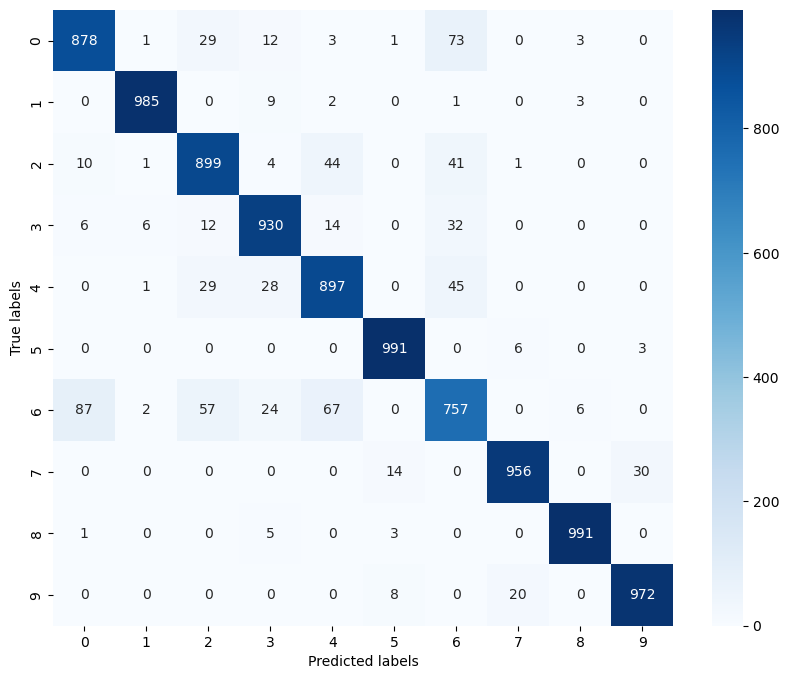

In [19]:
import seaborn as sns
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [20]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve((test_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

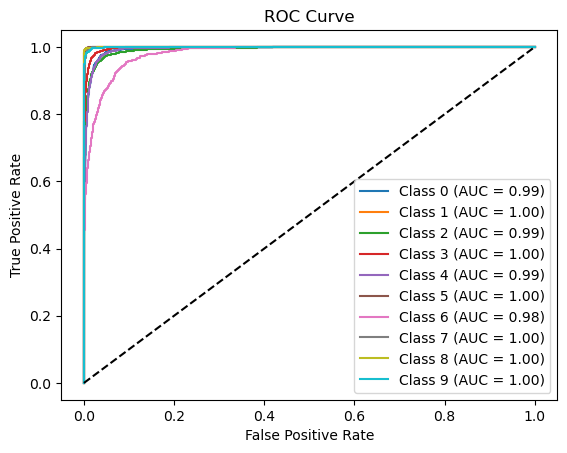

In [21]:
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='Class %d (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [23]:
iou_scores = []
for i in range(len(test_images)):
    y_true = tf.one_hot(test_labels[i], depth=10)
    y_pred = predictions[i]
    iou = calculate_iou(y_true, y_pred)
    iou_scores.append(iou)

In [24]:
average_iou = np.mean(iou_scores)
print("Average IoU:", average_iou)

Average IoU: 0.09999999999999999
